In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import cv2
from torchvision import models
from scipy.io import loadmat
from ultralytics import YOLO

model = YOLO('yolov8n.pt')

In [4]:
def preprocess_image(img):
    transform = transforms.Compose([
        transforms.Resize((640, 640)),
        transforms.ToTensor(),
    ])
    img_tensor = transform(img).unsqueeze(0)
    return img_tensor


def load_mat_as_tensor(mat_file_path):
    mat_data = loadmat(mat_file_path)
    img_data = mat_data['r']

    img_tensor = torch.from_numpy(img_data).float().permute(2, 0, 1) / 255.0
    
    img_pil = transforms.ToPILImage()(img_tensor)
    img_tensor = preprocess_image(img_pil)
    return img_tensor - 0.5


# FGSM Attack
def fgsm_attack(image, epsilon, gradient):
    sign_gradient = gradient.sign()
    perturbed_image = image + epsilon * sign_gradient
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image


def attack_yolo(img_path, noise_path, epsilon):
    img_tensor = preprocess_image(Image.open(img_path))
    
    # Display original image
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.imshow(img_tensor.squeeze().permute(1, 2, 0).numpy())
    plt.title("Original Image")
    plt.axis('off')

    # Perturb the image
    gradient = load_mat_as_tensor(noise_path)
    perturbed_image = fgsm_attack(img_tensor, epsilon, gradient)

    # Display perturbed image
    plt.subplot(122)
    plt.imshow(perturbed_image.squeeze().permute(1, 2, 0).numpy())
    plt.title(f"Perturbed Image (ε = {epsilon})")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return perturbed_image

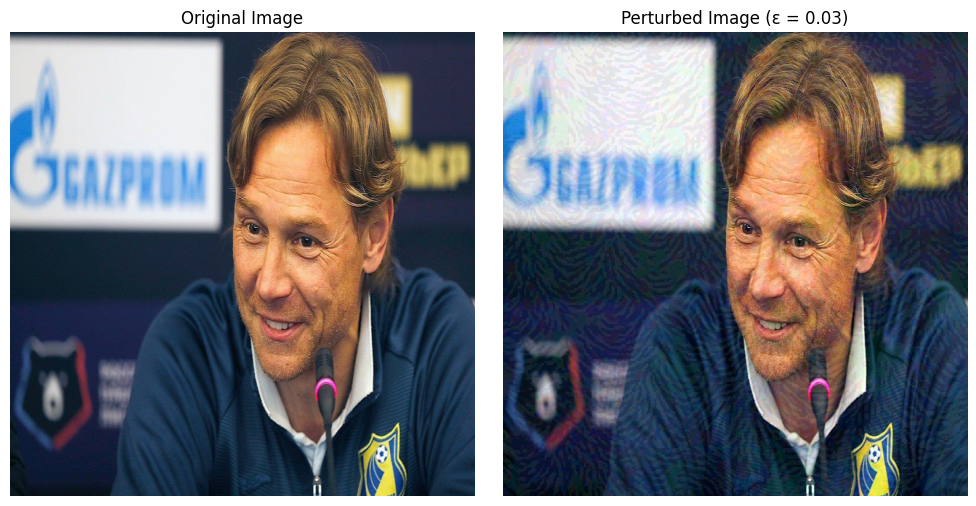

In [13]:
img_path = '../resources/universal_attack/karpin.jpg'
template_path = '../resources/universal_attack/ResNet-152.mat'
epsilon = .03
initial_img = preprocess_image(Image.open(img_path))
adversarial_img = attack_yolo(img_path, template_path, epsilon)

adversarial_img_np = adversarial_img.squeeze().detach().numpy()
adversarial_img_np = np.transpose(adversarial_img_np, (1, 2, 0))  

In [14]:
print(adversarial_img_np.shape)
print(Image.fromarray((adversarial_img_np * 255).astype(np.uint8)).size)

(640, 640, 3)
(640, 640)


In [15]:
Image.fromarray((adversarial_img_np * 255).astype(np.uint8)).save('../resources/universal_attack/adversarial_karpin.jpg')

In [7]:
def plot_bboxes(results):
    img = results[0].orig_img # original image
    names = results[0].names # class names dict
    scores = results[0].boxes.conf.numpy() # probabilities
    classes = results[0].boxes.cls.numpy() # predicted classes
    boxes = results[0].boxes.xyxy.numpy().astype(np.int32) # bboxes
    for score, cls, bbox in zip(scores, classes, boxes): # loop over all bboxes
        class_label = names[cls] # class name
        label = f"{class_label} : {score:0.2f}" # bbox label
        lbl_margin = 3 #label margin
        img = cv2.rectangle(img, (bbox[0], bbox[1]),
                            (bbox[2], bbox[3]),
                            color=(0, 0, 255),
                            thickness=1)
        label_size = cv2.getTextSize(label, # labelsize in pixels 
                                     fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                                     fontScale=1, thickness=1)
        lbl_w, lbl_h = label_size[0] # label w and h
        lbl_w += 2* lbl_margin # add margins on both sides
        lbl_h += 2*lbl_margin
        img = cv2.rectangle(img, (bbox[0], bbox[1]), # plot label background
                             (bbox[0]+lbl_w, bbox[1]-lbl_h),
                             color=(0, 0, 255), 
                             thickness=-1) # thickness=-1 means filled rectangle
        cv2.putText(img, label, (bbox[0]+ lbl_margin, bbox[1]-lbl_margin), # write label to the image
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=1.0, color=(255, 255, 255 ),
                    thickness=1)
    return img

In [8]:
results = model(initial_img)
results_perturbed = model(adversarial_img)
img_with_boxes = plot_bboxes(results)
img_with_boxes_perturbed = plot_bboxes(results_perturbed)


0: 640x640 1 person, 1 cell phone, 104.4ms
Speed: 0.3ms preprocess, 104.4ms inference, 7.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 person, 75.2ms
Speed: 0.0ms preprocess, 75.2ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)


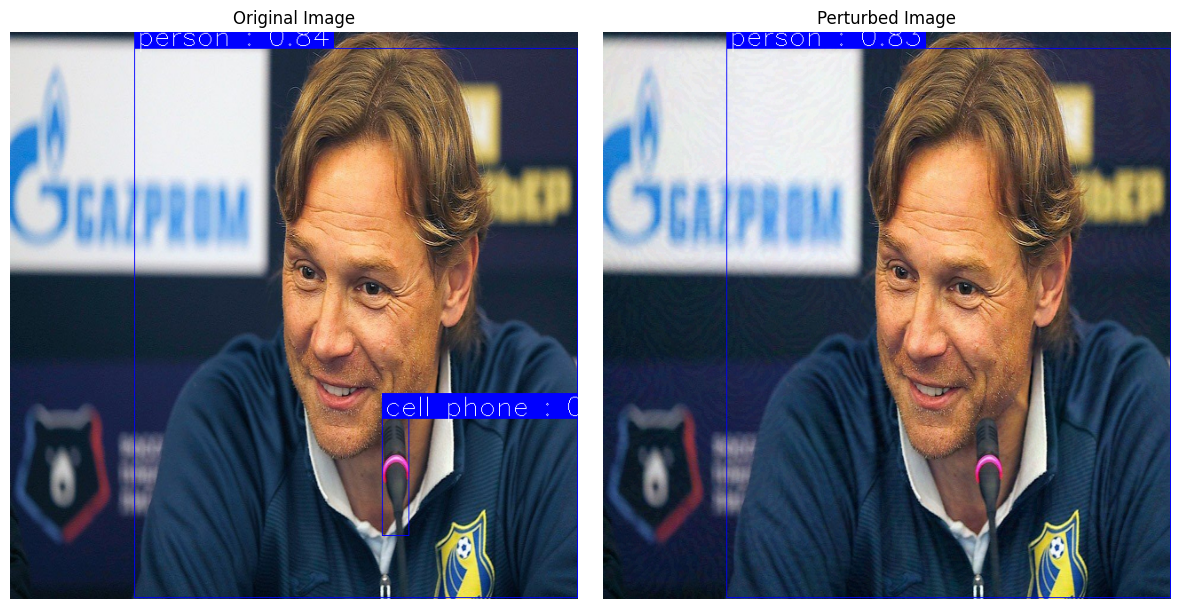

In [9]:
import matplotlib.pyplot as plt
from IPython.display import display

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(img_with_boxes)
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(img_with_boxes_perturbed)
axes[1].set_title('Perturbed Image')
axes[1].axis('off')

plt.tight_layout()